# Work and Variance Notebook for Propane --> Butane RJMC

The functions below generate independent snapshots of propane conformations and propose transformations to butane with the geometry proposal engine.  More specifically, for every conformation generated by the `create_iid_systems` function, there is a geometry proposal to butane.  Each proposal returns a rjmc_info list, a logp_forward, old reduced potentials, new reduced potentials, and old _core_ reduced potentials.  Information is also provided for the backward transformation.

Note: there is an option to conduct proposals (both forward and backward) that removes the variance in the work (up to the error of $r$, $\theta$ and $\phi$ discretizations) by neglecting angle terms between _core_ and _new_ atoms that couple the azimuthan and polar coordinates of adjacent atoms with the same bond atom.  Both work distributions are computed to demonstrate the reduction of variance in the RJMC generalized work.

In [1]:
################################################################################
import copy
from simtk import openmm, unit
from simtk.openmm import app
import os, os.path
import sys, math
import numpy as np
from functools import partial
from pkg_resources import resource_filename
from perses.rjmc import geometry
from perses.rjmc.topology_proposal import SystemGenerator, TopologyProposal, SmallMoleculeSetProposalEngine
from openeye import oechem
if sys.version_info >= (3, 0):
    from io import StringIO
    from subprocess import getstatusoutput
else:
    from cStringIO import StringIO
    from commands import getstatusoutput
from openmmtools.constants import kB
from openmmtools import alchemy, states
from perses.tests.utils import render_atom_mapping

################################################################################
# CONSTANTS
################################################################################

temperature = 300.0 * unit.kelvin
kT = kB * temperature
beta = 1.0/kT
LOGP_FORWARD_THRESHOLD = 1e3
REFERENCE_PLATFORM = openmm.Platform.getPlatformByName("Reference")

#create iid bead system and save
def create_iid_systems(system, positions, num_iterations):
    """
    Function to simulate i.i.d conformations of the initial molecule

    Returns
    -------
    iid_positions_A: numpy.ndarray
        num_iterations of independent initial molecule conformations
    """
    from openmmtools import integrators
    import tqdm
    _platform = REFERENCE_PLATFORM
    _integrator = integrators.LangevinIntegrator(temperature, 1./unit.picoseconds, 0.002*unit.picoseconds)
    _ctx = openmm.Context(system, _integrator)
    _ctx.setPositions(positions)
    openmm.LocalEnergyMinimizer.minimize(_ctx)

    _iid_positions_A=[]
    rp = []
    for _iteration in tqdm.trange(num_iterations):
        _integrator.step(1000)
        _state=_ctx.getState(getPositions=True)
        _iid_positions_A.append(_state.getPositions(asNumpy=True))
        rp.append(beta*_ctx.getState(getEnergy=True).getPotentialEnergy())

    return _iid_positions_A, rp

def test_work_variance(current_mol_name = 'propane', proposed_mol_name = 'butane', num_iterations = 1, same_starter = False, neglect_angles = True):
    """
    Generate a test vacuum topology proposal, current positions, and new positions triplet
    from two IUPAC molecule names.  Assert that the logp_forward < 1e3.
    This assertion will fail if the proposal order tool proposed the placement of the a carbon before a previously defined carbon in the alkane.

    Parameters
    ----------
    current_mol_name : str, optional
        name of the first molecule
    proposed_mol_name : str, optional
        name of the second molecule
    num_iterations : int 
        number of iid samples to generate and conduct geometry proposals

    Returns
    -------
    old_pos : list
        list of openmm Quantity objects for the positions of the old molecule
    old_pos_rp : numpy array
        array of reduced potentials corresponding to the old positions
    new_positions : list
        list of openmm Quantity objects for the positions of the new molecule
    old_pos_rp : numpy array
        array of reduced potentials corresponding to the new positions
    new_positions_initial_rp : numpy array
        array of reduced potentials of new positions at growth index == 0
    atom_placement_list: numpy array
        array of the rjmc info object output from the proposal
    logp_forwards : numpy array
        array of floats, each of which corresponds to a total logp_forward
    topology_proposal: topology_proposal object
    """
    from openmoltools import forcefield_generators

    from perses.tests.utils import createOEMolFromIUPAC, createSystemFromIUPAC, get_data_filename, compute_potential

    current_mol, unsolv_old_system, pos_old, top_old = createSystemFromIUPAC(current_mol_name)
    proposed_mol = createOEMolFromIUPAC(proposed_mol_name)

    initial_smiles = oechem.OEMolToSmiles(current_mol)
    final_smiles = oechem.OEMolToSmiles(proposed_mol)

    gaff_xml_filename = get_data_filename("data/gaff.xml")
    forcefield = app.ForceField(gaff_xml_filename, 'tip3p.xml')
    forcefield.registerTemplateGenerator(forcefield_generators.gaffTemplateGenerator)

    solvated_system = forcefield.createSystem(top_old, removeCMMotion=False)

    gaff_filename = get_data_filename('data/gaff.xml')
    system_generator = SystemGenerator([gaff_filename, 'amber99sbildn.xml', 'tip3p.xml'], forcefield_kwargs={'removeCMMotion': False, 'nonbondedMethod': app.NoCutoff})
    geometry_engine = geometry.FFAllAngleGeometryEngine(metadata=None, use_sterics=False, n_bond_divisions=100, n_angle_divisions=180, n_torsion_divisions=360, verbose=True, storage=None, bond_softening_constant=1.0, angle_softening_constant=1.0, neglect_angles = neglect_angles)
    proposal_engine = SmallMoleculeSetProposalEngine(
        [initial_smiles, final_smiles], system_generator, residue_name=current_mol_name)
    print("Generated proposal engine.")

    #generate topology proposal
    topology_proposal = proposal_engine.propose(solvated_system, top_old, current_mol=current_mol, proposed_mol=proposed_mol)
    print("topology_proposal complete.")

    # show atom mapping
    filename = str(current_mol_name)+str(proposed_mol_name)+'.pdf'
    render_atom_mapping(filename,current_mol,proposed_mol,topology_proposal.new_to_old_atom_map)


    print("old_system forces: {}".format(topology_proposal._old_system.getForces()))
    print("new_system forces: {}".format(topology_proposal._new_system.getForces()))


    #run simulation from old_positions and get energies thereof
    import tqdm
    if same_starter:
        old_pos_starter, old_pos_rp_starter = create_iid_systems(system = topology_proposal._old_system, positions = pos_old, num_iterations = 1)
        old_pos, old_pos_rp = [old_pos_starter[0] for i in range(num_iterations)], [old_pos_rp_starter[0] for i in range(num_iterations)]
    else:
        old_pos, old_pos_rp = create_iid_systems(system = topology_proposal._old_system, positions = pos_old, num_iterations = num_iterations)
    print("iid positions generator complete")

    logp_forwards, new_positions, new_positions_rp, new_positions_initial_rp, atom_placement_list = [], [], [], [], []
    logp_backwards, old_pos_rp, old_pos_initial_rp, atom_placement_list_rev  = [], [], [], []
    
    for iteration in tqdm.trange(num_iterations):
        #generate new positions with geometry engine
        new_pos, logp_forward = geometry_engine.propose(topology_proposal, old_pos[iteration], beta)
        atom_placements, atoms_with_positions_reduced_potential, final_context_reduced_potential = geometry_engine.forward_rjmc_info, geometry_engine.forward_atoms_with_positions_reduced_potential, geometry_engine.forward_final_context_reduced_potential
        neglected_angles_forward = geometry_engine.forward_neglected_angle_terms
        logp_back = geometry_engine.logp_reverse(topology_proposal, new_pos, old_pos[iteration], beta)
        _lp_rev_old_pos, lp_rev_info, lp_rev_awprp, lp_rev_fcrp = geometry_engine.reverse_new_positions, geometry_engine.reverse_rjmc_info, geometry_engine.reverse_atoms_with_positions_reduced_potential, geometry_engine.reverse_final_context_reduced_potential
        neglected_angles_reverse = geometry_engine.reverse_neglected_angle_terms
        new_positions.append(new_pos); atom_placement_list.append(atom_placements)
        new_positions_rp.append(final_context_reduced_potential)
        logp_forwards.append(logp_forward)
        new_positions_initial_rp.append(atoms_with_positions_reduced_potential)
        
        logp_backwards.append(logp_back)
        old_pos_initial_rp.append(lp_rev_awprp)
        old_pos_rp.append(lp_rev_fcrp)
        atom_placement_list_rev.append(lp_rev_info)
    print("neglected angles forward : {}".format(neglected_angles_forward))
    print("neglected_angles reverse : {}".format(neglected_angles_reverse))


    return old_pos, np.array(old_pos_rp),  new_positions, np.array(new_positions_rp), np.array(new_positions_initial_rp), np.array(atom_placement_list), np.array(logp_forwards), topology_proposal, np.array(logp_backwards), np.array(old_pos_rp), np.array(old_pos_initial_rp), np.array(atom_placement_list_rev)



The line below executes the functions above and with 100 iterations.

In [2]:
old_pos, old_pos_rp, new_positions, new_positions_rp_corrected, new_positions_initial_rp, atom_placement_list, logp_forwards, topology_proposal, logp_backwards, old_pos_rp, old_pos_init_rp, atom_placement_list_rev = test_work_variance(current_mol_name = 'propane', proposed_mol_name = 'butane', num_iterations = 100, same_starter = False, neglect_angles = False)

DEBUG:openmoltools.openeye:keep_confs was set to 1. Molecule positions will be reset.
DEBUG:openmoltools.openeye:MOL
DEBUG:parmed.openmm.parameters:Valid patch combinations:
DEBUG:openmoltools.openeye:keep_confs was set to 1. Molecule positions will be reset.
DEBUG:openmoltools.openeye:MOL
DEBUG:parmed.openmm.parameters:Valid patch combinations:
INFO:proposal_engine:Building new Topology object...


Generated proposal engine.


DEBUG:openmoltools.openeye:keep_confs was set to 1. Molecule positions will be reset.
DEBUG:openmoltools.openeye:MOL
DEBUG:parmed.openmm.parameters:Valid patch combinations:
INFO:proposal_engine:Proposed transformation would delete 1 atoms and create 4 atoms.


topology_proposal complete.
old_system forces: [<simtk.openmm.openmm.HarmonicBondForce; proxy of <Swig Object of type 'OpenMM::HarmonicBondForce *' at 0x000001AA12908180> >, <simtk.openmm.openmm.HarmonicAngleForce; proxy of <Swig Object of type 'OpenMM::HarmonicAngleForce *' at 0x000001AA12908B70> >, <simtk.openmm.openmm.PeriodicTorsionForce; proxy of <Swig Object of type 'OpenMM::PeriodicTorsionForce *' at 0x000001AA12908B40> >, <simtk.openmm.openmm.NonbondedForce; proxy of <Swig Object of type 'OpenMM::NonbondedForce *' at 0x000001AA12908600> >]
new_system forces: [<simtk.openmm.openmm.HarmonicBondForce; proxy of <Swig Object of type 'OpenMM::HarmonicBondForce *' at 0x000001AA12908B10> >, <simtk.openmm.openmm.HarmonicAngleForce; proxy of <Swig Object of type 'OpenMM::HarmonicAngleForce *' at 0x000001AA12908AE0> >, <simtk.openmm.openmm.PeriodicTorsionForce; proxy of <Swig Object of type 'OpenMM::PeriodicTorsionForce *' at 0x000001AA12908AB0> >, <simtk.openmm.openmm.NonbondedForce; pro

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:16<00:00,  6.54it/s]


iid positions generator complete


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:24<00:00,  4.17it/s]


neglected angles forward : []
neglected_angles reverse : []


Now we can compute the total forward work, which is defined as $$w_{fwd} = \log(p_{fwd}) + \Delta u $$
It is important to clarify that $ \Delta u $ is defined as the final valence reduced potential of the forward molecule less the reduced potential of the forward molecule before any new atoms are proposed (i.e. the reduced potential for force terms that are not considered in the growth context).  In this regime, $\log(p_{rev})$ is zero since there are no unique old atoms. 

The total backward work is analogously defined, except as $$w_{bkwd} = -\log(p_{bkwd}) + \Delta u $$.  In this case, $\Delta u$ is defined as the negative-valued energy difference between the _old core_ energy and the total _old_ system.

In [3]:
#compute the total work from the final logp_forwards and the total change in energy
total_work_forward = logp_forwards + new_positions_rp_corrected - new_positions_initial_rp
total_work_backward = -logp_backwards + old_pos_init_rp - old_pos_rp


We can also compute the work _per atom_...


In [4]:
#compute the per-atom work for the sequential logp_forwards and the sequential change in energy
def generate_per_atom_array(atom_placement_list):
    per_atom_work = {0: [], 1: [], 2: [], 3: []}; total_energy_change_list = []; total_logp_forward_list = []
    lnZ_phis_lst = []
    combined_lnZ_r_theta = []
    for iteration_index, iteration_list in enumerate(atom_placement_list):
        total_energy_change = 0.; total_logp_forward = 0.0; lnZ_phis = []; lnZ_others = []
        for placement_index, atom_array in enumerate(iteration_list):
            atom_index, added_energy, logp_r, logp_theta, logp_phi, detJ, proposal_prob = atom_array['atom_index'], atom_array['added_energy'], atom_array['logp_r'], atom_array['logp_theta'], atom_array['logp_phi'], atom_array['log_detJ'], atom_array['proposal_prob']
            u_r, u_theta = atom_array['u_r'], atom_array['u_theta']
            u_phi = added_energy - u_r - u_theta
            lnZ_phi = -(logp_phi + u_phi)
            lnZ_phis.append(lnZ_phi)
            total_energy_change += added_energy

            work_from_logps = proposal_prob + logp_r + logp_theta + logp_phi - detJ + added_energy
            per_atom_work[placement_index].append(work_from_logps)
            lnZ_others.append(logp_r + logp_theta - detJ + u_r + u_theta)
        
        combined_lnZ_r_theta.append(lnZ_others)
        total_energy_change_list.append(total_energy_change)
        lnZ_phis_lst.append(lnZ_phis)
    
    lnZ_phis_variance = [np.std(np.array(lnZ_phis_lst)[:,i]) for i in range(np.array(lnZ_phis_lst).shape[1])]
    lnZ_others_variance = [np.std(np.array(combined_lnZ_r_theta)[:,i]) for i in range(np.array(combined_lnZ_r_theta).shape[1])]
    print("lnZ_phis_stds : {}".format(lnZ_phis_variance))
    print("lnZ_r_theta_stds : {}".format(lnZ_others_variance))
    #turn dict into a numpy array of shape (atoms, iterations)
    per_atom_array = []
    for idx in per_atom_work.keys():
        lst = per_atom_work[idx]
        if lst != []:
            per_atom_array.append(lst)
    #print(per_atom_array)
    
    # Add per_atom works from all atoms in each iteration
    per_atom_array = np.array(per_atom_array)
    atoms, iterations = per_atom_array.shape
    total_works = np.array([np.sum(per_atom_array[:,iteration]) for iteration in range(iterations)])
    return per_atom_array, total_works, lnZ_phis_lst, per_atom_work

#now execute
per_atom_array, total_works, lnZ_phis_lst, per_atom_work = generate_per_atom_array(atom_placement_list)
per_atom_array_bkwd, total_works_bkwd, lnZ_phis_lst_bkwd, per_atom_work_bkwd = generate_per_atom_array(atom_placement_list_rev)

lnZ_phis_stds : [1.1370417088262121, 0.01670430911863312, 0.4536989411562199, 1.8475122495070853]
lnZ_r_theta_stds : [0.07276395014038843, 0.07237046233752775, 0.06140460082865727, 0.07095256068784772]
lnZ_phis_stds : [0.5870922780872571]
lnZ_r_theta_stds : [0.06559996072999277]


We should also make sure that for each iteration, the previously computed forward/backward work is approximately equal to the computed forward/backward work from the _per atom_ work summation

In [5]:
assert all(abs(i-j) < 1e-3 for i,j in zip(logp_forwards + new_positions_rp_corrected - new_positions_initial_rp, total_works))
assert all(abs(i+j) < 1e-3 for i,j in zip(-logp_backwards + old_pos_init_rp - old_pos_rp, total_works_bkwd))

Now we can plot the _per atom_ work and the total accumulated work 

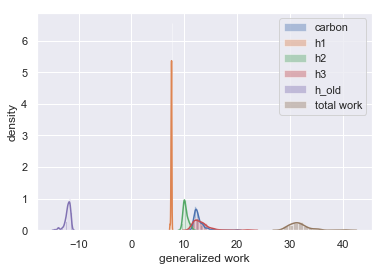

In [7]:
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
sns.set(color_codes = True)


for key, atom_name in zip(per_atom_work.keys(), ["carbon", "h1", "h2", "h3"]):
    ax1 = sns.distplot(np.array(per_atom_work[key]), label = atom_name, norm_hist = True)
ax1 = sns.distplot(-1*np.array(total_works_bkwd), label = "h_old")

#now plot total generalized work
ax1 = sns.distplot(total_works - total_works_bkwd, label = "total work", norm_hist = True)
ax1.set(xlabel = "generalized work", ylabel = "density")
ax1.legend(loc = 'best')


#plt.savefig("propane_to_butane_forward_works.pdf")


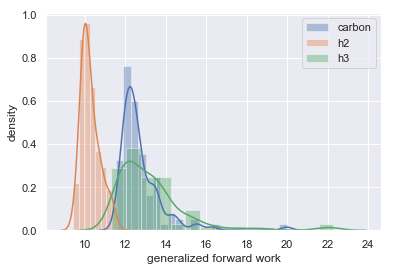

In [8]:
for key, atom_name in zip(per_atom_work.keys(), ["carbon", "h1", "h2", "h3"]):
    if atom_name != "h1":
        ax1 = sns.distplot(np.array(per_atom_work[key]), label = atom_name, norm_hist = True)
ax1.set(xlabel = "generalized forward work", ylabel = "density")
ax1.legend(loc = 'best')

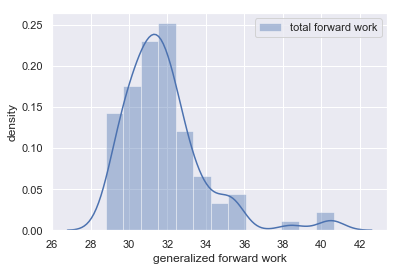

In [9]:
#now plot total generalized work
ax1 = sns.distplot(total_works - total_works_bkwd, label = "total forward work", norm_hist = True)
ax1.set(xlabel = "generalized forward work", ylabel = "density")
ax1.legend(loc = 'best')

It is worthwhile to make the following observations...

1.  the butant carbon atom has a variance since it is being proposed with two core hydrogens on the terminal propane carbon
2.  the first hydrogen added to the butane carbon has a variance that is bounded by the numerical error in `geometry.py` since it's position is only a function of $r$, $\theta$, and $\phi$
3.  on the other hand, when we add hydrogen 2 and 3, these terms are coupled to the _branch angle_ potentials of the previously placed hydrogens.  This contributes to work variance, and since the form of all the valence terms are positive defined (i.e. energy grows monotonically with the number of atoms placed), the work can only accumulate for identical atoms placed on the same node

Knowing that _h2_ and _h3_ are dependent on the positions of the previously placed hydrogen(s), we can look at the $\theta$ and $\phi$ dependence of $\log Z_{\phi}$.  For simplicity's sake, we will look at the $\log Z_{\phi}$ of _h2_ 

[Text(0, 0.5, 'lnZ_phi_h1'), Text(0.5, 0, 'theta h1')]

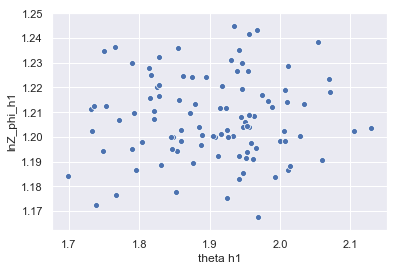

In [10]:
#plotting lnZ_phi against theta and phi_prev for correlations
lnZ_phis_lst = np.array(lnZ_phis_lst)
#we are particularly keen on hydrogen 2...
cs, h1s, h2s, h3s = atom_placement_list[:,0], atom_placement_list[:,1], atom_placement_list[:,2], atom_placement_list[:,3] 
theta_c, thetas_h1, thetas_h2, thetas_h3 = np.array([i['theta'] for i in cs]), np.array([i['theta'] for i in h1s]), np.array([i['theta'] for i in h2s]), np.array([i['theta'] for i in h3s])


lnZ_phis_carbon = lnZ_phis_lst[:,0]
lnZ_phis_h1 = lnZ_phis_lst[:,1]
lnZ_phis_h2 = lnZ_phis_lst[:,2]
lnZ_phis_h3 = lnZ_phis_lst[:,3]

#perhaps we need to load the phis of the previously placed atoms first
phis_carbon, phis_h1, phis_h2, phis_h3 = np.array([i['phi'] for i in cs]), np.array([i['phi'] for i in h1s]), np.array([i['phi'] for i in h2s]), np.array([i['phi'] for i in h3s])
ax = sns.scatterplot(thetas_h1, lnZ_phis_h1)
ax.set(xlabel = "theta h1", ylabel = 'lnZ_phi_h1')

[Text(0, 0.5, 'lnZ_phi h2'), Text(0.5, 0, 'theta h1')]

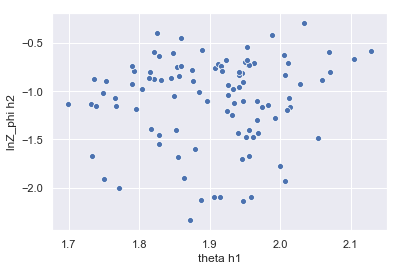

In [11]:
ax = sns.scatterplot(thetas_h1, lnZ_phis_h2)
ax.set(xlabel = "theta h1", ylabel = 'lnZ_phi h2')

[Text(0, 0.5, 'lnZ_phi h2'), Text(0.5, 0, 'phi h1')]

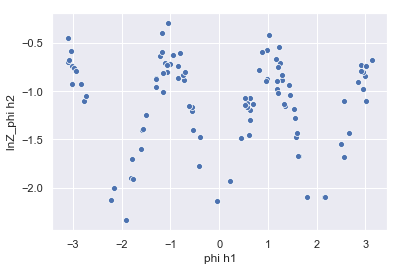

In [12]:
ax = sns.scatterplot(phis_h1, lnZ_phis_h2)
ax.set(xlabel = "phi h1", ylabel = 'lnZ_phi h2')

[Text(0, 0.5, 'lnZ_phi h3'), Text(0.5, 0, 'phi h2')]

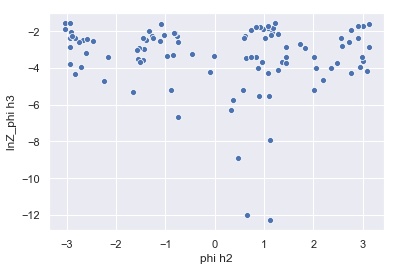

In [13]:
ax = sns.scatterplot(phis_h2, lnZ_phis_h3)
ax.set(xlabel = "phi h2", ylabel = 'lnZ_phi h3')

It is clear that in this case of two atoms connected to a common node, the $\phi$ of _h1_ is much more correlated to $\log Z_{\phi}$ for _h2_ than is the $\theta$ of _h2_

For good measure, it is also advisable to generate a distribution of proposals from the _same_ old starting structure...

In [14]:
old_pos, old_pos_rp, new_positions, new_positions_rp_corrected, new_positions_initial_rp, atom_placement_list, logp_forwards, topology_proposal, logp_backwards, old_pos_rp, old_pos_init_rp, atom_placement_list_rev = test_work_variance(current_mol_name = 'propane', proposed_mol_name = 'butane', num_iterations = 100, same_starter = True, neglect_angles = False)

DEBUG:openmoltools.openeye:keep_confs was set to 1. Molecule positions will be reset.
DEBUG:openmoltools.openeye:MOL
DEBUG:parmed.openmm.parameters:Valid patch combinations:
DEBUG:openmoltools.openeye:keep_confs was set to 1. Molecule positions will be reset.
DEBUG:openmoltools.openeye:MOL
DEBUG:parmed.openmm.parameters:Valid patch combinations:


Generated proposal engine.


INFO:proposal_engine:Building new Topology object...
DEBUG:openmoltools.openeye:keep_confs was set to 1. Molecule positions will be reset.
DEBUG:openmoltools.openeye:MOL
DEBUG:parmed.openmm.parameters:Valid patch combinations:
INFO:proposal_engine:Proposed transformation would delete 1 atoms and create 4 atoms.


topology_proposal complete.
old_system forces: [<simtk.openmm.openmm.HarmonicBondForce; proxy of <Swig Object of type 'OpenMM::HarmonicBondForce *' at 0x000001AA12289690> >, <simtk.openmm.openmm.HarmonicAngleForce; proxy of <Swig Object of type 'OpenMM::HarmonicAngleForce *' at 0x000001AA12289840> >, <simtk.openmm.openmm.PeriodicTorsionForce; proxy of <Swig Object of type 'OpenMM::PeriodicTorsionForce *' at 0x000001AA12289780> >, <simtk.openmm.openmm.NonbondedForce; proxy of <Swig Object of type 'OpenMM::NonbondedForce *' at 0x000001AA16940F00> >]
new_system forces: [<simtk.openmm.openmm.HarmonicBondForce; proxy of <Swig Object of type 'OpenMM::HarmonicBondForce *' at 0x000001AA16940F00> >, <simtk.openmm.openmm.HarmonicAngleForce; proxy of <Swig Object of type 'OpenMM::HarmonicAngleForce *' at 0x000001AA16940F60> >, <simtk.openmm.openmm.PeriodicTorsionForce; proxy of <Swig Object of type 'OpenMM::PeriodicTorsionForce *' at 0x000001AA16940BA0> >, <simtk.openmm.openmm.NonbondedForce; pro

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.81s/it]


iid positions generator complete


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:24<00:00,  4.10it/s]


neglected angles forward : []
neglected_angles reverse : []


With this, we can take a look at how the $\theta$ for the carbon atom affects it's own $\log Z_{\phi}$ 

lnZ_phis_stds : [0.6134782141388491, 0.016750167493548435, 0.46173031546341925, 1.1516325976360422]
lnZ_r_theta_stds : [0.08167494694118575, 0.06964444995832872, 0.06099550935947224, 0.07166249480126015]


[Text(0, 0.5, 'lnZ_phi carbon'), Text(0.5, 0, 'theta carbon')]

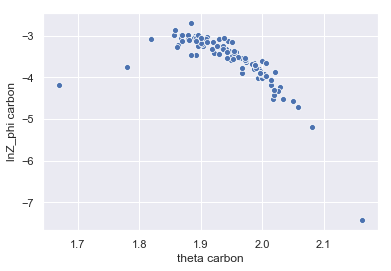

In [15]:
per_atom_array, total_works, lnZ_phis_list, _ = generate_per_atom_array(atom_placement_list)
lnZ_phis_list = np.array(lnZ_phis_list)
cs = atom_placement_list[:,0]
theta_c = np.array([i['theta'] for i in cs])
lnZ_phis_carbon = lnZ_phis_list[:,0]

ax_ = sns.scatterplot(theta_c, lnZ_phis_carbon)
ax_.set(xlabel = "theta carbon", ylabel = 'lnZ_phi carbon')

So it is clear that the $\log Z_{\phi}$  is correlated to the proposal angle $\theta$ (as expected); however,  making a joint proposal on $\theta$ and $\phi$ would not solve the problem of reducing variance when considering the addition of new atoms at a common node (since Out[12] and Out[13] show a strong correlation between the current atom $\log Z_{\phi}$ and the previous atom $\phi$.

## Now another look...but with coupled angle potentials neglected...

DEBUG:openmoltools.openeye:keep_confs was set to 1. Molecule positions will be reset.
DEBUG:openmoltools.openeye:MOL
DEBUG:parmed.openmm.parameters:Valid patch combinations:
DEBUG:openmoltools.openeye:keep_confs was set to 1. Molecule positions will be reset.
DEBUG:openmoltools.openeye:MOL
DEBUG:parmed.openmm.parameters:Valid patch combinations:


Generated proposal engine.


INFO:proposal_engine:Building new Topology object...
DEBUG:openmoltools.openeye:keep_confs was set to 1. Molecule positions will be reset.
DEBUG:openmoltools.openeye:MOL
DEBUG:parmed.openmm.parameters:Valid patch combinations:
INFO:proposal_engine:Proposed transformation would delete 1 atoms and create 4 atoms.


topology_proposal complete.
old_system forces: [<simtk.openmm.openmm.HarmonicBondForce; proxy of <Swig Object of type 'OpenMM::HarmonicBondForce *' at 0x000001AA16940DB0> >, <simtk.openmm.openmm.HarmonicAngleForce; proxy of <Swig Object of type 'OpenMM::HarmonicAngleForce *' at 0x000001AA16940990> >, <simtk.openmm.openmm.PeriodicTorsionForce; proxy of <Swig Object of type 'OpenMM::PeriodicTorsionForce *' at 0x000001AA16940C00> >, <simtk.openmm.openmm.NonbondedForce; proxy of <Swig Object of type 'OpenMM::NonbondedForce *' at 0x000001AA16940D20> >]
new_system forces: [<simtk.openmm.openmm.HarmonicBondForce; proxy of <Swig Object of type 'OpenMM::HarmonicBondForce *' at 0x000001AA16940960> >, <simtk.openmm.openmm.HarmonicAngleForce; proxy of <Swig Object of type 'OpenMM::HarmonicAngleForce *' at 0x000001AA16940DB0> >, <simtk.openmm.openmm.PeriodicTorsionForce; proxy of <Swig Object of type 'OpenMM::PeriodicTorsionForce *' at 0x000001AA16940990> >, <simtk.openmm.openmm.NonbondedForce; pro

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  6.43it/s]


iid positions generator complete


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:24<00:00,  4.23it/s]


neglected angles forward : [4, 5, 19, 20, 21]
neglected_angles reverse : [14, 15]
lnZ_phis_stds : [0.018348224934261165, 0.05128692219384877, 0.04689044857686027, 0.050014138864368604]
lnZ_r_theta_stds : [0.07627086924396739, 0.07269118535449401, 0.06775071020304353, 0.07122802726309811]
lnZ_phis_stds : [0.007186961289737143]
lnZ_r_theta_stds : [0.07179915685674025]


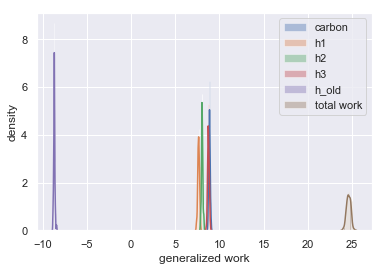

In [16]:
old_pos, old_pos_rp, new_positions, new_positions_rp_corrected, new_positions_initial_rp, atom_placement_list, logp_forwards, topology_proposal, logp_backwards, old_pos_rp, old_pos_init_rp, atom_placement_list_rev = test_work_variance(current_mol_name = 'propane', proposed_mol_name = 'butane', num_iterations = 100, same_starter = False, neglect_angles = True)

#compute the total work from the final logp_forwards and the total change in energy
total_work_forward = logp_forwards + new_positions_rp_corrected - new_positions_initial_rp
total_work_backward = -logp_backwards + old_pos_init_rp - old_pos_rp

#now execute
per_atom_array, total_works, lnZ_phis_lst, per_atom_work = generate_per_atom_array(atom_placement_list)
per_atom_array_bkwd, total_works_bkwd, lnZ_phis_lst_bkwd, per_atom_work_bkwd = generate_per_atom_array(atom_placement_list_rev)

assert all(abs(i-j) < 1e-3 for i,j in zip(logp_forwards + new_positions_rp_corrected - new_positions_initial_rp, total_works))
assert all(abs(i+j) < 1e-3 for i,j in zip(-logp_backwards + old_pos_init_rp - old_pos_rp, total_works_bkwd))



for key, atom_name in zip(per_atom_work.keys(), ["carbon", "h1", "h2", "h3"]):
    ax1 = sns.distplot(np.array(per_atom_work[key]), label = atom_name, norm_hist = True)
ax1 = sns.distplot(-1*np.array(total_works_bkwd), label = "h_old")

#now plot total generalized work
ax1 = sns.distplot(total_works - total_works_bkwd, label = "total work", norm_hist = True)
ax1.set(xlabel = "generalized work", ylabel = "density")
ax1.legend(loc = 'best')